In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

# Configuración estética para gráficos
plt.style.use('ggplot')
sns.set(font_scale=1.2)
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14

# Cargar los datos
df = pd.read_csv('C:\\Users\\SyncthingServiceAcct\\UOC\\TFG\\training_log.csv')

In [3]:
# Definir etapas según Excel (corregidas)
etapas = [
    {"nombre": "Inicial (sin entropía)", "inicio": 1, "fin": 650, "entropia": 0.0, "color": "#808080"},
    {"nombre": "Introducción entropía", "inicio": 650, "fin": 775, "entropia": 0.01, "color": "#FF6B6B"},
    {"nombre": "Aumento entropía", "inicio": 775, "fin": 1085, "entropia": 0.05, "color": "#4ECDC4"},
    {"nombre": "Descenso entropía", "inicio": 1085, "fin": 1535, "entropia": 0.01, "color": "#45B7D1"},
    {"nombre": "Aumento entropía + Config", "inicio": 1535, "fin": 2020, "entropia": 0.02, "color": "#96CEB4"},
    {"nombre": "Ajuste LR (1e-5)", "inicio": 2020, "fin": 3170, "entropia": 0.05, "color": "#FECA57"},
    {"nombre": "Ajuste LR (1e-4)", "inicio": 3170, "fin": 4145, "entropia": 0.04, "color": "#FF9FF3"},
    {"nombre": "Estabilización", "inicio": 4145, "fin": 5445, "entropia": 0.02, "color": "#54A0FF"},
    {"nombre": "Final (epochs=8)", "inicio": 5445, "fin": df['episode'].max(), "entropia": 0.015, "color": "#5F27CD"}
]

def add_stage_backgrounds(ax, etapas, alpha=0.1):
    """Añade fondos de colores para cada etapa"""
    for etapa in etapas:
        ax.axvspan(etapa["inicio"], etapa["fin"], 
                  alpha=alpha, color=etapa["color"], 
                  label=f'{etapa["nombre"]} (ε={etapa["entropia"]})')

def add_stage_separators(ax, etapas):
    """Añade líneas verticales para separar etapas"""
    for i, etapa in enumerate(etapas[1:], 1):  # Empezar desde la segunda etapa
        ax.axvline(x=etapa["inicio"], color='black', linestyle='--', 
                  alpha=0.7, linewidth=1.5)


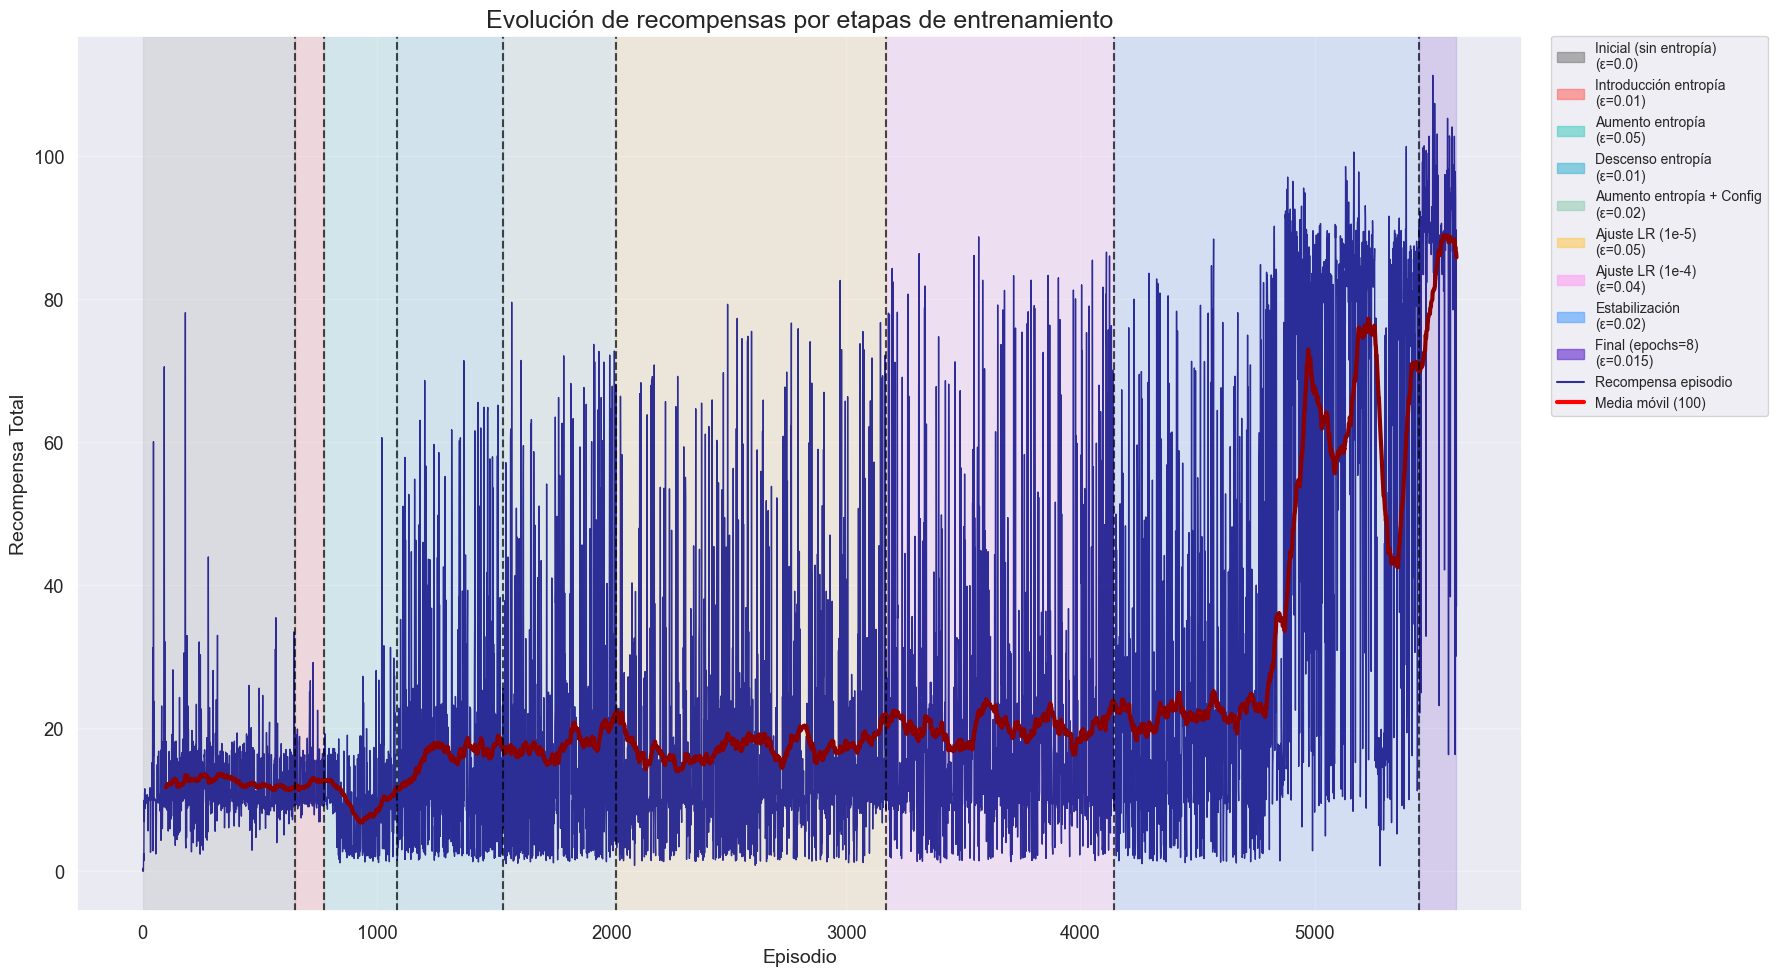

In [4]:
# 1. GRÁFICA 1: Recompensas por episodios con etapas
fig, ax = plt.subplots(figsize=(18, 10))

# Añadir fondos de etapas
add_stage_backgrounds(ax, etapas, alpha=0.15)

# Plotear datos
ax.plot(df['episode'], df['total_reward'], label='Recompensa por episodio', 
        color='navy', alpha=0.8, linewidth=1)

# Media móvil
window_size = 100
df['moving_avg_reward'] = df['total_reward'].rolling(window=window_size).mean()
ax.plot(df['episode'], df['moving_avg_reward'], 
        label=f'Media móvil (ventana={window_size})', 
        color='darkred', linewidth=3)

# Añadir separadores
add_stage_separators(ax, etapas)

ax.set_title('Evolución de recompensas por etapas de entrenamiento', fontsize=18)
ax.set_xlabel('Episodio')
ax.set_ylabel('Recompensa Total')
ax.grid(True, alpha=0.3)

# Crear leyenda personalizada
legend_elements = [mpatches.Patch(color=etapa["color"], alpha=0.6, 
                                 label=f'{etapa["nombre"]}\n(ε={etapa["entropia"]})') 
                  for etapa in etapas]
legend_elements.extend([
    plt.Line2D([0], [0], color='navy', alpha=0.8, label='Recompensa episodio'),
    plt.Line2D([0], [0], color='red', linewidth=3, label=f'Media móvil ({window_size})')
])

ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.02, 1), 
         borderaxespad=0, fontsize=10)
plt.tight_layout()
plt.savefig('reward_stages_detailed.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\cexpo\AppData\Local\Temp\ipykernel_6164\2108613380.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  reward_by_timestep = df.groupby('timestep_bin')['total_reward'].agg(['mean', 'std', 'count']).reset_index()


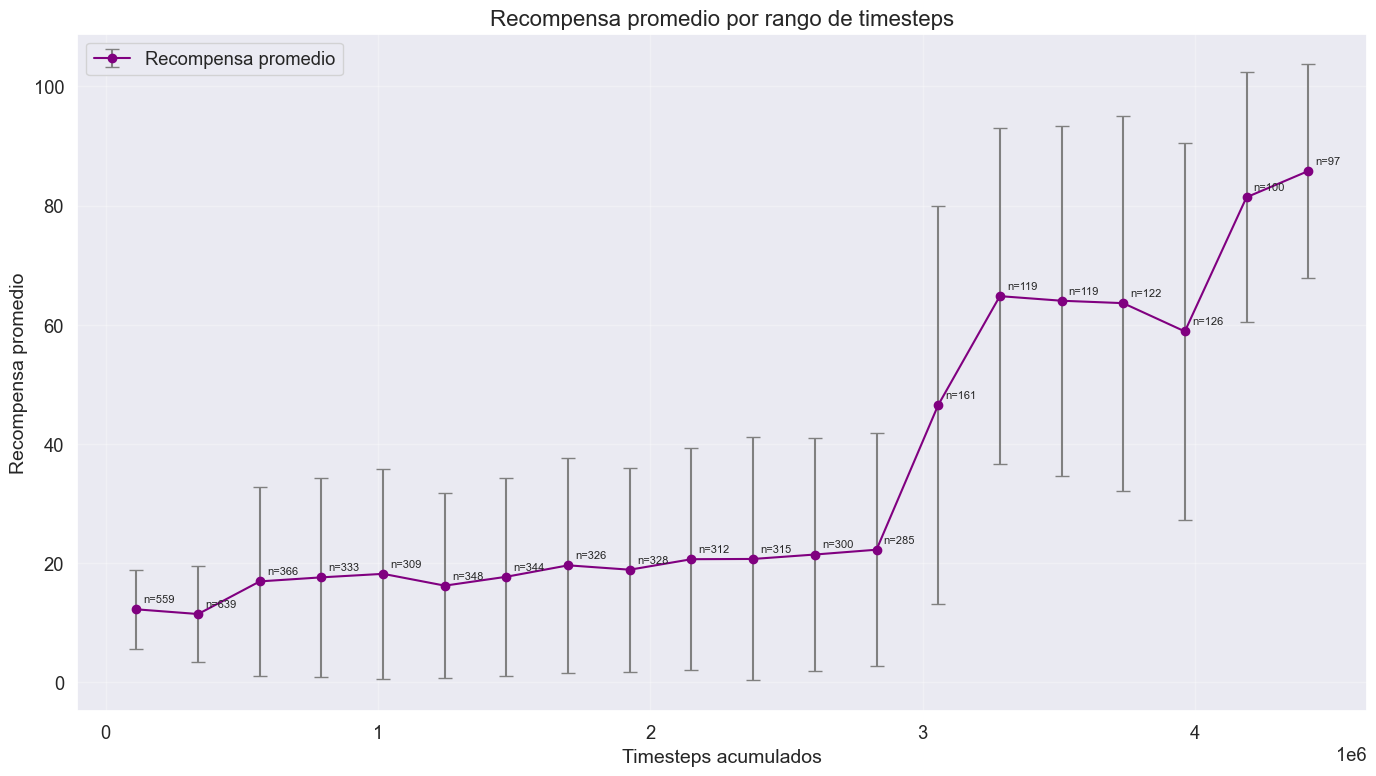

In [5]:
# 2. Análisis de recompensas según timesteps (promedio)
df['cumulative_timesteps'] = df['episode_length'].cumsum()
# Crear bins de timesteps para agrupar
num_bins = 20
df['timestep_bin'] = pd.cut(df['cumulative_timesteps'], bins=num_bins)
# Calcular la recompensa promedio por bin
reward_by_timestep = df.groupby('timestep_bin')['total_reward'].agg(['mean', 'std', 'count']).reset_index()
reward_by_timestep['bin_center'] = reward_by_timestep['timestep_bin'].apply(lambda x: x.mid)

# Gráfico de recompensas promedio por timestep con barras de error
fig, ax = plt.subplots(figsize=(14, 8))
ax.errorbar(reward_by_timestep['bin_center'], 
            reward_by_timestep['mean'], 
            yerr=reward_by_timestep['std'],
            fmt='o-', 
            ecolor='gray', 
            capsize=5, 
            color='purple', 
            label='Recompensa promedio')

ax.set_title('Recompensa promedio por rango de timesteps')
ax.set_xlabel('Timesteps acumulados')
ax.set_ylabel('Recompensa promedio')
ax.legend()
ax.grid(True, alpha=0.3)

# Anotar tamaño de muestra en cada punto
for i, row in reward_by_timestep.iterrows():
    ax.annotate(f'n={int(row["count"])}', 
                xy=(row['bin_center'], row['mean']),
                xytext=(5, 5),
                textcoords='offset points',
                fontsize=8)

plt.tight_layout()
plt.savefig('avg_reward_by_timestep.png', dpi=300)
plt.show()




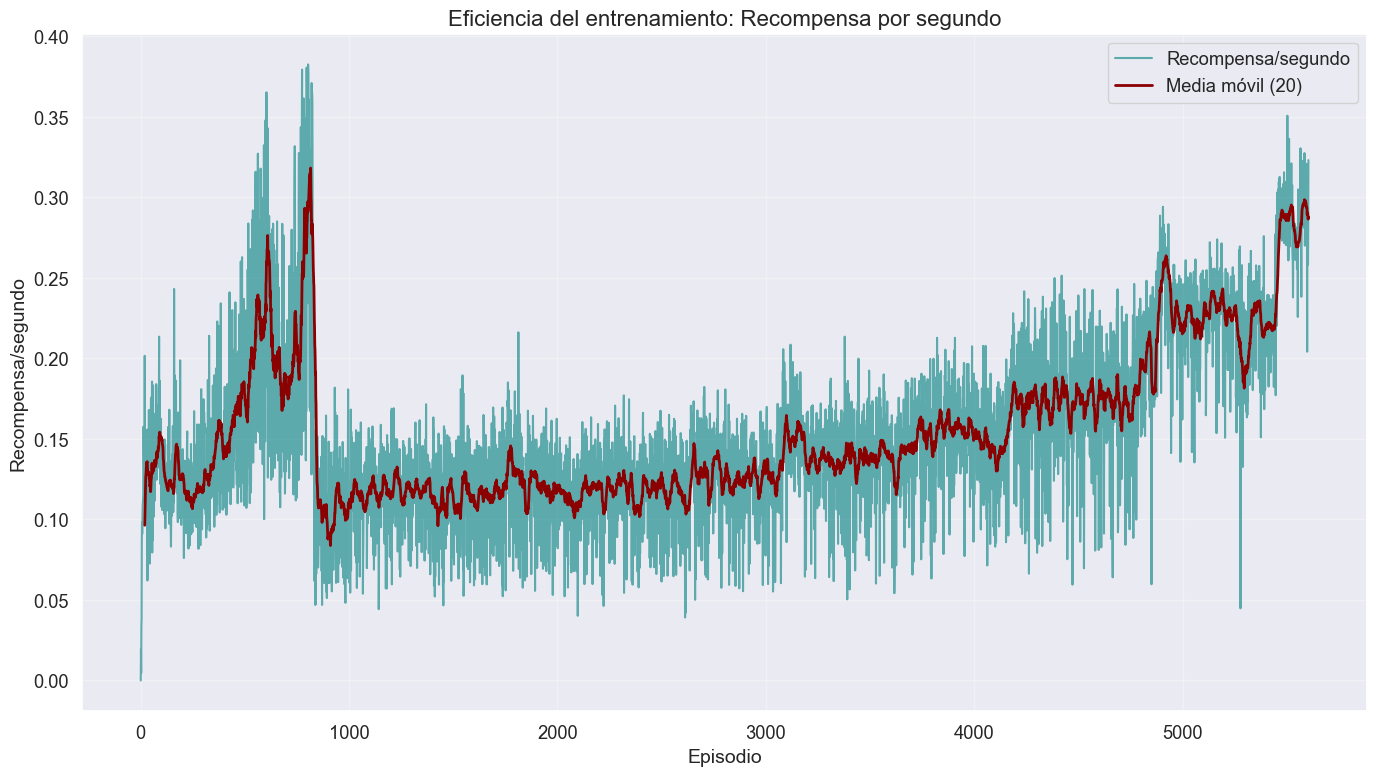

In [6]:
# 3. Análisis de eficiencia: Recompensa vs. Tiempo

# Calcular la recompensa por segundo de tiempo de entrenamiento
df['reward_per_second'] = df['total_reward'] / df['time_taken']

fig, ax = plt.subplots(figsize=(14, 8))
ax.plot(df['episode'], df['reward_per_second'], label='Recompensa/segundo', color='teal', alpha=0.6)
ax.plot(df['episode'], df['reward_per_second'].rolling(window=20).mean(), 
        label='Media móvil (20)', color='darkred', linewidth=2)

ax.set_title('Eficiencia del entrenamiento: Recompensa por segundo')
ax.set_xlabel('Episodio')
ax.set_ylabel('Recompensa/segundo')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('reward_efficiency.png', dpi=300)
plt.show()


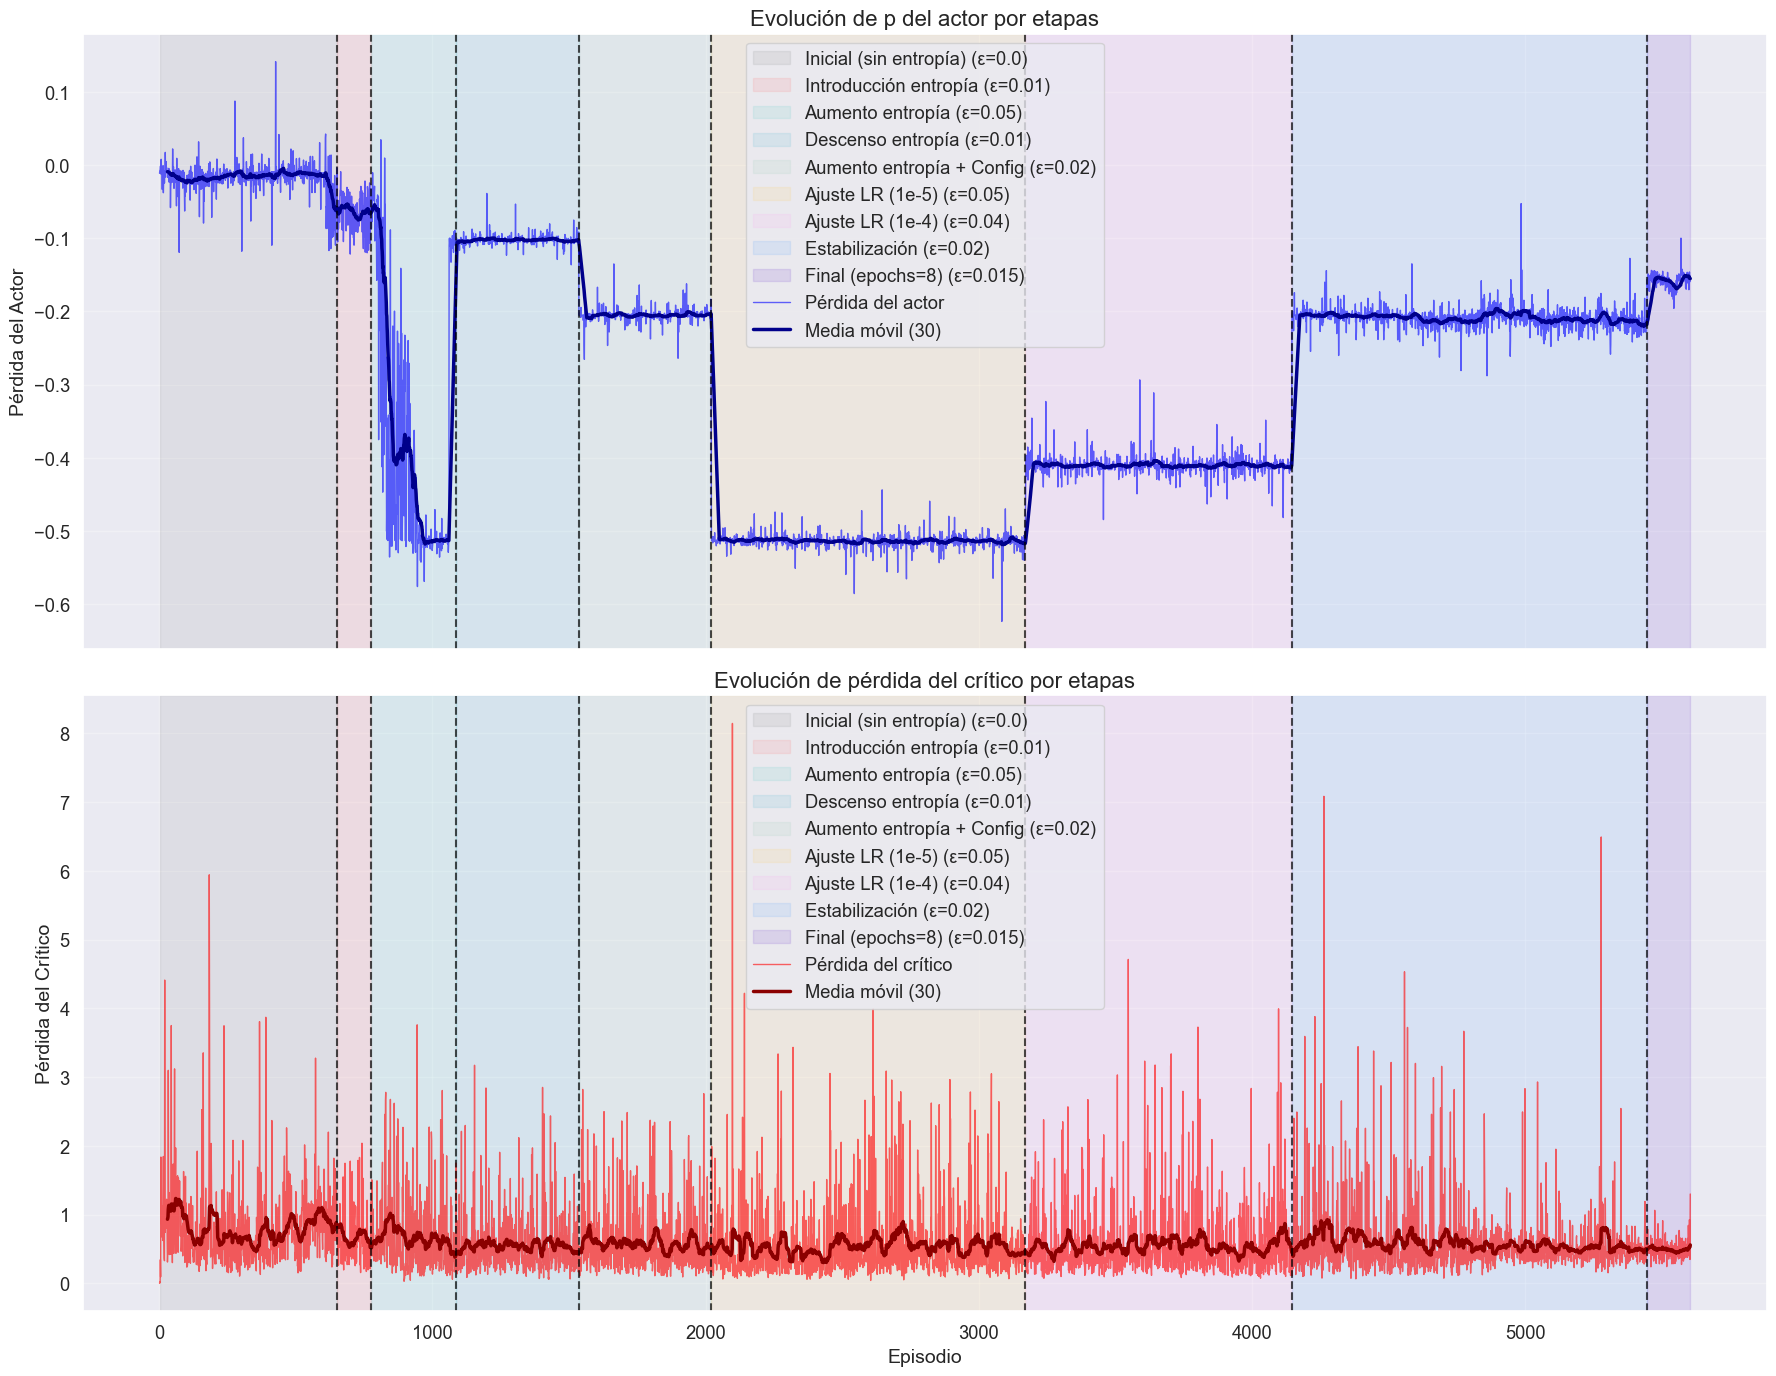

In [7]:
# 4. Pérdidas del Actor y Crítico por etapas
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 14), sharex=True)

# Actor Loss
add_stage_backgrounds(ax1, etapas, alpha=0.12)
ax1.plot(df['episode'], df['actor_loss'], color='blue', alpha=0.6, linewidth=1, label='Pérdida del actor')
ax1.plot(df['episode'], df['actor_loss'].rolling(window=30).mean(), 
         color='darkblue', linewidth=2.5, label='Media móvil (30)')
add_stage_separators(ax1, etapas)
ax1.set_title('Evolución de p del actor por etapas')
ax1.set_ylabel('Pérdida del Actor')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Critic Loss
add_stage_backgrounds(ax2, etapas, alpha=0.12)
ax2.plot(df['episode'], df['critic_loss'], color='red', alpha=0.6, linewidth=1, label='Pérdida del crítico')
ax2.plot(df['episode'], df['critic_loss'].rolling(window=30).mean(), 
         color='darkred', linewidth=2.5, label='Media móvil (30)')
add_stage_separators(ax2, etapas)
ax2.set_title('Evolución de pérdida del crítico por etapas')
ax2.set_xlabel('Episodio')
ax2.set_ylabel('Pérdida del Crítico')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('losses_stages_detailed.png', dpi=300, bbox_inches='tight')
plt.show()

In [8]:
def get_stage_data(etapa):
    """Obtiene los datos filtrados para una etapa específica"""
    return df[(df['episode'] >= etapa["inicio"]) & (df['episode'] < etapa["fin"])]

def calcular_evolucion_interna(data, porcentaje=30):
    """Calcula la evolución entre el primer y último tercio de una etapa"""
    if len(data) < 6:
        return None, None, None
    
    n_inicial = max(1, int(len(data) * porcentaje / 100))
    n_final = max(1, int(len(data) * porcentaje / 100))
    
    datos_iniciales = data.head(n_inicial)
    datos_finales = data.tail(n_final)
    
    media_inicial = datos_iniciales['total_reward'].mean()
    media_final = datos_finales['total_reward'].mean()
    cambio = media_final - media_inicial
    
    return media_inicial, media_final, cambio

# PROCESAR TODAS LAS ETAPAS
for i, etapa in enumerate(etapas):
    data = get_stage_data(etapa)
    
    # Estadísticas básicas
    media_etapa = data['total_reward'].mean()
    std_etapa = data['total_reward'].std()
    min_etapa = data['total_reward'].min()
    max_etapa = data['total_reward'].max()
    n_episodios = len(data)
    
    # Evolución respecto etapa anterior
    if i > 0:
        data_anterior = get_stage_data(etapas[i-1])
        media_anterior = data_anterior['total_reward'].mean()
        cambio_vs_anterior = media_etapa - media_anterior
        pct_cambio_vs_anterior = (cambio_vs_anterior / media_anterior) * 100
        
        cambio_text = f"• Cambio vs anterior: {cambio_vs_anterior:+.2f} ({pct_cambio_vs_anterior:+.1f}%)"
    else:
        cambio_text = "• Cambio vs anterior: --- (Primera etapa)"
    
    # Evolución interna
    inicial, final, cambio_interno = calcular_evolucion_interna(data)
    if cambio_interno is not None:
        evolucion_text = f"• Evolución interna: {inicial:.1f} → {final:.1f} ({cambio_interno:+.2f})"
    else:
        evolucion_text = "• Evolución interna: --- (Datos insuficientes)"
    
    # Imprimir información de la etapa
    print(f"ETAPA {i+1}: {etapa['nombre'].upper()}")
    print(f"• Entropía: {etapa['entropia']}")
    print(f"• Episodios: {etapa['inicio']} - {etapa['fin']} (Total: {n_episodios})")
    print(f"• Recompensa promedio: {media_etapa:.2f} ± {std_etapa:.2f}")
    print(f"• Rango: [{min_etapa:.1f}, {max_etapa:.1f}]")
    print(cambio_text)
    print(evolucion_text)
    print()

ETAPA 1: INICIAL (SIN ENTROPÍA)
• Entropía: 0.0
• Episodios: 1 - 650 (Total: 653)
• Recompensa promedio: 12.22 ± 6.45
• Rango: [0.0, 78.2]
• Cambio vs anterior: --- (Primera etapa)
• Evolución interna: 12.3 → 11.7 (-0.59)

ETAPA 2: INTRODUCCIÓN ENTROPÍA
• Entropía: 0.01
• Episodios: 650 - 775 (Total: 125)
• Recompensa promedio: 12.59 ± 4.12
• Rango: [6.9, 29.2]
• Cambio vs anterior: +0.37 (+3.0%)
• Evolución interna: 12.1 → 12.1 (-0.02)

ETAPA 3: AUMENTO ENTROPÍA
• Entropía: 0.05
• Episodios: 775 - 1085 (Total: 310)
• Recompensa promedio: 9.70 ± 6.57
• Rango: [1.2, 60.7]
• Cambio vs anterior: -2.89 (-23.0%)
• Evolución interna: 10.0 → 11.9 (+1.92)

ETAPA 4: DESCENSO ENTROPÍA
• Entropía: 0.01
• Episodios: 1085 - 1535 (Total: 450)
• Recompensa promedio: 16.49 ± 15.55
• Rango: [1.3, 71.4]
• Cambio vs anterior: +6.79 (+70.0%)
• Evolución interna: 16.0 → 16.5 (+0.48)

ETAPA 5: AUMENTO ENTROPÍA + CONFIG
• Entropía: 0.02
• Episodios: 1535 - 2020 (Total: 485)
• Recompensa promedio: 18.45 ± 17.

In [9]:
# 1. Duración total del entrenamiento
duracion_total = df['time_taken'].sum()
horas = int(duracion_total // 3600)
minutos = int((duracion_total % 3600) // 60)
segundos = int(duracion_total % 60)

print(f"• Duración total: {duracion_total:.1f} segundos ({horas}h {minutos}m {segundos}s)")

# 2. Timesteps acumulados al final
timesteps_totales = df['episode_length'].sum()
print(f"• Timesteps totales: {timesteps_totales:,}")

# 3. Número total de episodios
num_episodios = len(df)
print(f"• Número de episodios: {num_episodios}")

# 4. Recompensa máxima y su episodio
max_reward = df['total_reward'].max()
episodio_max = df.loc[df['total_reward'].idxmax(), 'episode']
print(f"• Recompensa máxima: {max_reward:.2f} (Episodio {episodio_max})")

# 5. Promedios en diferentes fases
# Primeros 200 episodios
primeros_200 = df.head(200)['total_reward'].mean()
print(f"• Promedio primeros 200 episodios: {primeros_200:.2f}")

# Últimos 200 episodios
ultimos_200 = df.tail(200)['total_reward'].mean()
print(f"• Promedio últimos 200 episodios: {ultimos_200:.2f}")

# 200 episodios en el medio
medio_inicio = (len(df) - 200) // 2
medio_fin = medio_inicio + 200
medio_200 = df.iloc[medio_inicio:medio_fin]['total_reward'].mean()
episodios_medio = f"{df.iloc[medio_inicio]['episode']}-{df.iloc[medio_fin-1]['episode']}"
print(f"• Promedio 200 episodios medio (eps. {episodios_medio}): {medio_200:.2f}")

# 6. Mejora total
mejora_total = ultimos_200 - primeros_200
pct_mejora = (mejora_total / primeros_200) * 100
print(f"• Mejora total (últimos vs primeros 200): {mejora_total:+.2f} ({pct_mejora:+.1f}%)")


• Duración total: 792082.7 segundos (220h 1m 22s)
• Timesteps totales: 4,529,231
• Número de episodios: 5608
• Recompensa máxima: 111.35 (Episodio 5503)
• Promedio primeros 200 episodios: 12.23
• Promedio últimos 200 episodios: 83.51
• Promedio 200 episodios medio (eps. 2701-2900): 17.83
• Mejora total (últimos vs primeros 200): +71.28 (+582.7%)


In [10]:
# Recompensa máxima y su episodio
max_reward = df['total_reward'].max()
episodio_max = df.loc[df['total_reward'].idxmax(), 'episode']
print(f"Recompensa máxima: {max_reward:.2f} (Episodio {episodio_max})")

# Promedio primeros 200 episodios
primeros_200 = df.head(200)['total_reward'].mean()
print(f"Promedio primeros 200 episodios: {primeros_200:.2f}")

# Promedio últimos 200 episodios
ultimos_200 = df.tail(200)['total_reward'].mean()
print(f"Promedio últimos 200 episodios: {ultimos_200:.2f}")

# Promedio 200 episodios del medio
medio_inicio = (len(df) - 200) // 2
medio_fin = medio_inicio + 200
medio_200 = df.iloc[medio_inicio:medio_fin]['total_reward'].mean()
episodios_medio = f"{df.iloc[medio_inicio]['episode']}-{df.iloc[medio_fin-1]['episode']}"
print(f"Promedio 200 episodios medio (eps. {episodios_medio}): {medio_200:.2f}")

# Mejora total
mejora_total = ultimos_200 - primeros_200
pct_mejora = (mejora_total / primeros_200) * 100
print(f"Mejora total: {mejora_total:+.2f} ({pct_mejora:+.1f}%)")

print("="*40)

Recompensa máxima: 111.35 (Episodio 5503)
Promedio primeros 200 episodios: 12.23
Promedio últimos 200 episodios: 83.51
Promedio 200 episodios medio (eps. 2701-2900): 17.83
Mejora total: +71.28 (+582.7%)
